In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.inference import BeliefPropagation
import itertools
import tkinter as tk
from tkinter import messagebox
from tkinter import font


#import numpy as np
#from pgmpy.factors.discrete import DiscreteFactor

# 定义贝叶斯网络结构
model = BayesianNetwork([
    ('education', 'value'), ('education', 'common interests'),
    ('wealth', 'common interests'), ('wealth', 'appearance'),
    ('appearance', 'outer'), ('outer', 'together'),
    ('common interests', 'internal'), ('value', 'internal'),('internal',"together")
])

# 定义变量的条件概率分布
cpd_education = TabularCPD(variable='education', variable_card=2, values=[[0.6], [0.4]])
cpd_wealth = TabularCPD(variable='wealth', variable_card=2, values=[[0.6], [0.4]])
cpd_value = TabularCPD(variable='value', variable_card=2,
                       evidence=['education'],
                       evidence_card=[2],
                       values=[[0.7, 0.4],  # value = 0
                               [0.3, 0.6]])  # value = 1
cpd_appearance = TabularCPD(variable='appearance', variable_card=2,
                            evidence=['wealth'],
                            evidence_card=[2],
                            values=[[0.7, 0.3], [0.3, 0.7]])
cpd_outer = TabularCPD(variable='outer', variable_card=2,
                          evidence=['appearance'],
                          evidence_card=[2],
                          values=[[0.7, 0.3], [0.3, 0.7]])
cpd_common_interests = TabularCPD(variable='common interests', variable_card=2,
                                  evidence=['education', 'wealth'],
                                  evidence_card=[2, 2],
                                  values=[[0.8, 0.7, 0.6, 0.5],
                                          [0.2, 0.3, 0.4, 0.5]])
cpd_internal = TabularCPD(variable='internal', variable_card=2,
                          evidence=['common interests', 'value'],
                          evidence_card=[2, 2],
                          values=[[0.8, 0.7, 0.6, 0.5],
                                  [0.2, 0.3, 0.4, 0.5]])
cpd_together = TabularCPD(variable='together', variable_card=2,
                          evidence=['internal', 'outer'],
                          evidence_card=[2, 2],
                          values=[[0.9, 0.8, 0.7, 0.6],
                                  [0.1, 0.2, 0.3, 0.4]])


# 将条件概率分布添加到贝叶斯网络中
model.add_cpds(cpd_education, cpd_wealth, cpd_value, cpd_appearance, cpd_outer, cpd_common_interests, cpd_internal, cpd_together)

# 检查模型是否正确定义
if model.check_model():
    print("模型定义正确")
else:
    print("模型定义有误")


# 构建Junction Tree并输出
junction_tree = model.to_junction_tree()
print(junction_tree)



C:\Users\缪永亮\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


模型定义正确
JunctionTree with 4 nodes and 3 edges


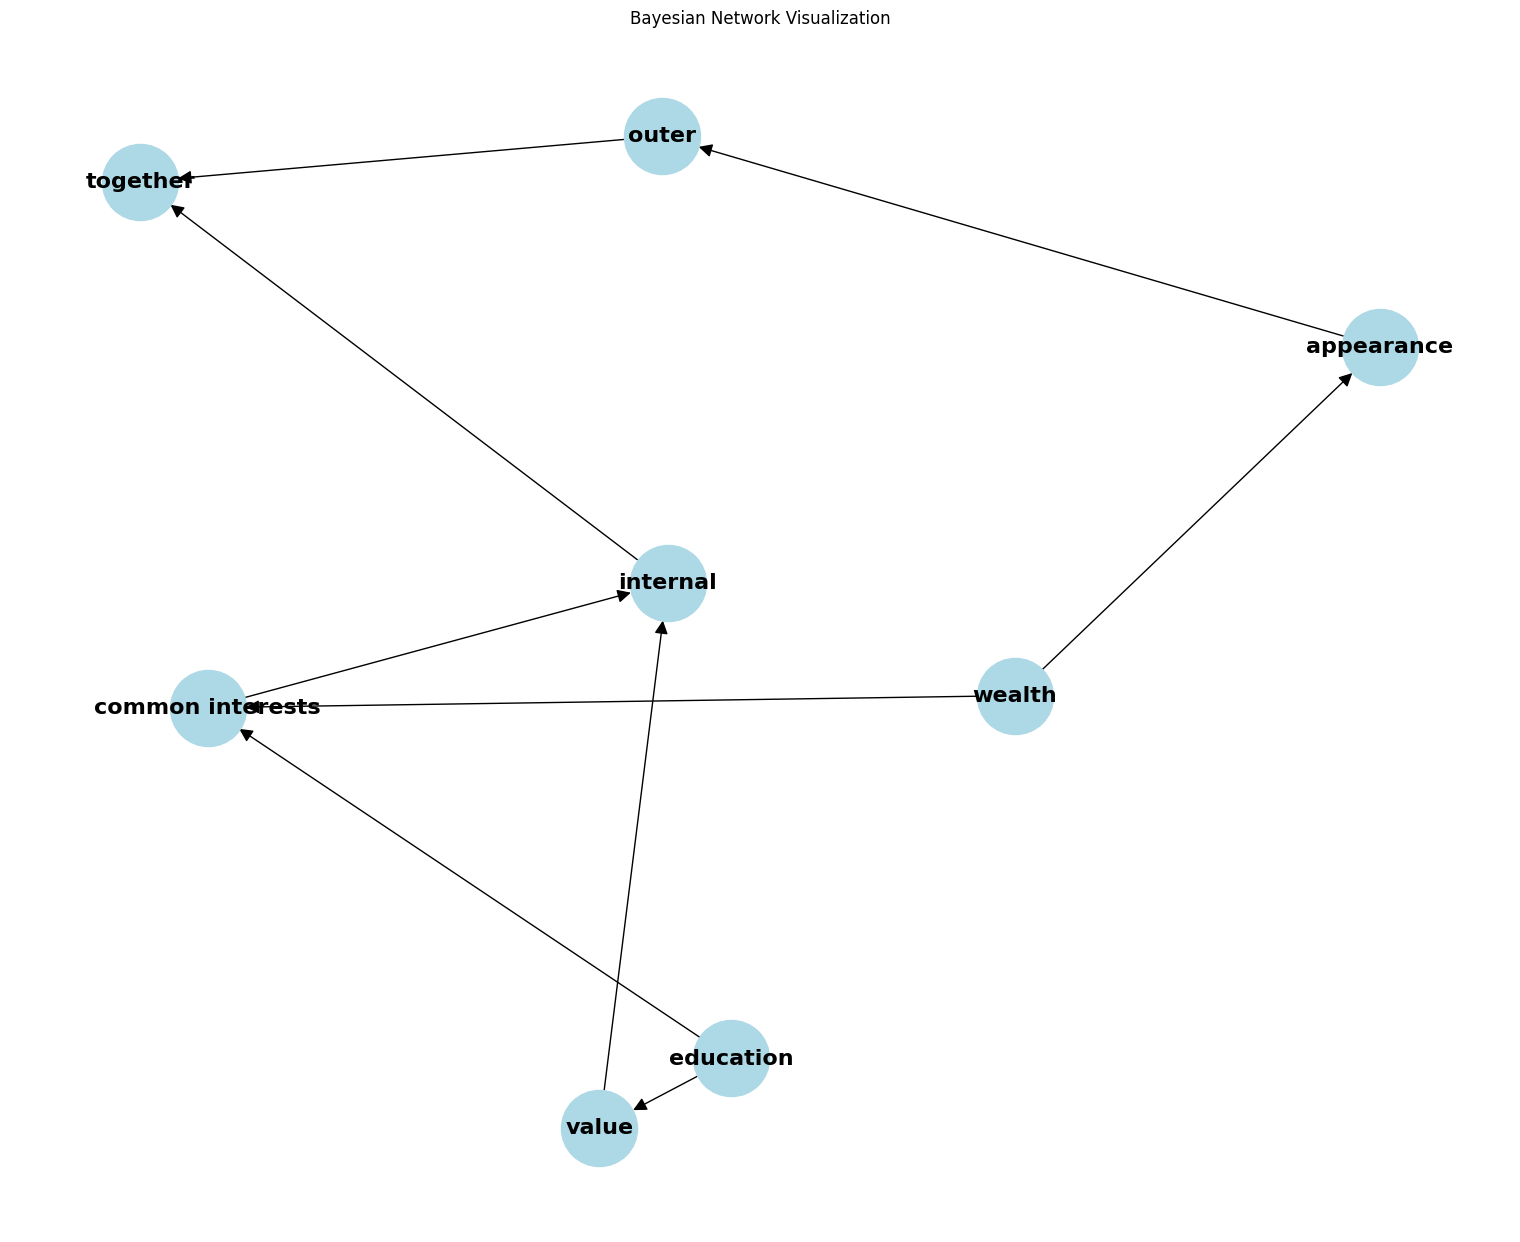

In [2]:
# 创建一个空的networkx图
bayesian_network_graph = nx.DiGraph()

# 添加贝叶斯网络的节点到图中
bayesian_network_graph.add_nodes_from(model.nodes())

# 添加贝叶斯网络的边到图中
bayesian_network_graph.add_edges_from(model.edges())

# 绘制图形
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(bayesian_network_graph)
nx.draw(bayesian_network_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=16, font_weight='bold', arrowsize=20)
plt.title("Bayesian Network Visualization")
plt.show()

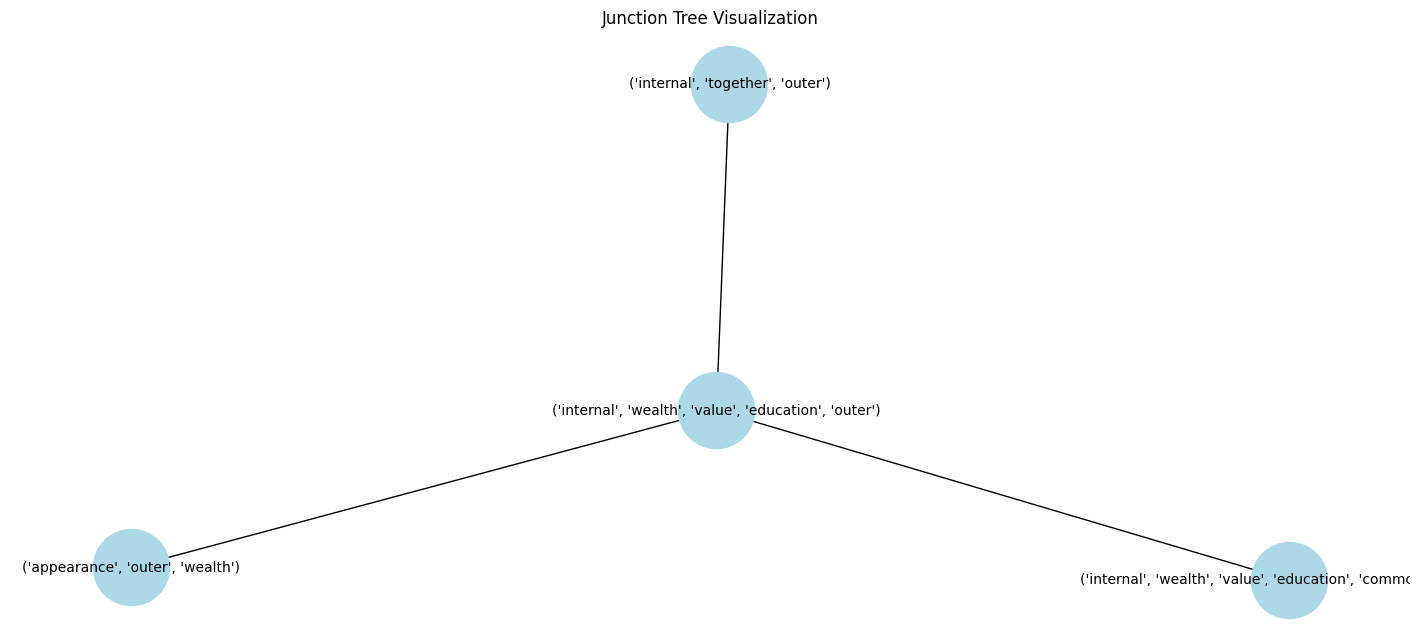

In [3]:
# 创建一个空的networkx图
junction_tree_graph = nx.Graph()

# 添加Junction Tree的节点到图中
for node in junction_tree.nodes():
    junction_tree_graph.add_node(node)

# 添加Junction Tree的边到图中
for edge in junction_tree.edges():
    junction_tree_graph.add_edge(*edge)

# 绘制图形
plt.figure(figsize=(14, 6))
pos = nx.spring_layout(junction_tree_graph)
nx.draw(junction_tree_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, arrowsize=20)
plt.title("Junction Tree Visualization")
plt.show()



# Inference

In [4]:
# 创建 BeliefPropagation 对象，并传入 Junction Tree 对象
bp = BeliefPropagation(junction_tree)

# 执行消息传递算法
bp.calibrate()

# 获取最终的边缘概率分布
marginals = bp.get_clique_beliefs()

# 打印最终的边缘概率分布
print(marginals)

{('internal', 'wealth', 'value', 'education', 'common interests'): <DiscreteFactor representing phi(common interests:2, wealth:2, value:2, internal:2, education:2) at 0x1672d8b3a48>, ('internal', 'wealth', 'value', 'education', 'outer'): <DiscreteFactor representing phi(value:2, wealth:2, outer:2, internal:2, education:2) at 0x1672d8b3488>, ('internal', 'together', 'outer'): <DiscreteFactor representing phi(outer:2, internal:2, together:2) at 0x1672d8b3c48>, ('appearance', 'outer', 'wealth'): <DiscreteFactor representing phi(outer:2, wealth:2, appearance:2) at 0x1672d8cc248>}


In [5]:
# 遍历每个因子及其对应的概率值
for clique, factor in marginals.items():
    print("因子:", clique)
    print("概率值:")
    
    # 获取变量的数量
    num_variables = len(factor.cardinality)
    
    # 动态地确定循环的次数
    num_assignments = [range(card) for card in factor.cardinality]
    for assignment in itertools.product(*num_assignments):
        probability = factor.values[tuple(assignment)]
        print(f"当 {' '.join(f'{var}={val}' for var, val in zip(factor.variables, assignment))} 时，对应的概率值为 {probability:.3f}")
    print()

因子: ('internal', 'wealth', 'value', 'education', 'common interests')
概率值:
当 common interests=0 wealth=0 value=0 internal=0 education=0 时，对应的概率值为 0.161
当 common interests=0 wealth=0 value=0 internal=0 education=1 时，对应的概率值为 0.046
当 common interests=0 wealth=0 value=0 internal=1 education=0 时，对应的概率值为 0.040
当 common interests=0 wealth=0 value=0 internal=1 education=1 时，对应的概率值为 0.012
当 common interests=0 wealth=0 value=1 internal=0 education=0 时，对应的概率值为 0.060
当 common interests=0 wealth=0 value=1 internal=0 education=1 时，对应的概率值为 0.060
当 common interests=0 wealth=0 value=1 internal=1 education=0 时，对应的概率值为 0.026
当 common interests=0 wealth=0 value=1 internal=1 education=1 时，对应的概率值为 0.026
当 common interests=0 wealth=1 value=0 internal=0 education=0 时，对应的概率值为 0.094
当 common interests=0 wealth=1 value=0 internal=0 education=1 时，对应的概率值为 0.026
当 common interests=0 wealth=1 value=0 internal=1 education=0 时，对应的概率值为 0.024
当 common interests=0 wealth=1 value=0 internal=1 education=1 时，对应的概率值为 0.006
当 

# query (1. 调用包做query   2. 手动实现query算法作为验证)

In [6]:
# 创建VariableElimination对象
ve = VariableElimination(model)

# 定义查询变量
query_variables = ['together']  # 将要查询的多个变量放入列表中

# 已观测到的变量及其值
evidence = {'education': 0, 'wealth': 0}

# 执行变量消去算法来进行推断
query_result = ve.query(variables=query_variables, evidence=evidence)

# 打印推断结果
print(query_result)

+-------------+-----------------+
| together    |   phi(together) |
+=============+=================+
| together(0) |          0.8040 |
+-------------+-----------------+
| together(1) |          0.1960 |
+-------------+-----------------+


In [7]:
def custom_query(model, query_variable, observed_variables):
    '''
        input: the whole model F, the query variable, observed variables.
        output: the probability of the query variable given by observed variables

        algorithm:
            1. initialize the Elimination_order list
            2. while Eliminiation_order is not empty:
                    1. eliminate the first variable z from elimination_order
                    2. call function eliminate(model, F, z)
            3. set h to be the product of all the factors in F
            4. instantiate observed variables in h to their observed values
            5. normalization 
            6. return
    '''
    # Convert all CPDs to factors
    F = {node: model.get_cpds(node).to_factor() for node in model.nodes()}
    
    if isinstance(query_variable, list):
        results = {}
        for query_var in query_variable:
            # Determine the elimination order: excluding the query variable and observed variables
            elimination_order = [var for var in model.nodes() if var != query_var and var not in observed_variables]

            # Eliminate variables in the order specified
            for var in elimination_order:
                F = eliminate(F, var)

            # Compute the product of all remaining factors
            final_factor = None
            for factor in F.values():
                if final_factor is None:
                    final_factor = factor
                else:
                    final_factor = final_factor.product(factor, inplace=False)

            # Apply observed values to variables
            if observed_variables:
                final_factor.reduce([(var, val) for var, val in observed_variables.items()], inplace=True)

            # Normalize
            final_factor.normalize()

            # Extract the marginal probability of the query variable
            results[query_var] = final_factor.values
        return results
    else:
        # Determine the elimination order: excluding the query variable and observed variables
        elimination_order = [var for var in model.nodes() if var != query_variable and var not in observed_variables]

        # Eliminate variables in the order specified
        for var in elimination_order:
            F = eliminate(F, var)

        # Compute the product of all remaining factors
        final_factor = None
        for factor in F.values():
            if final_factor is None:
                final_factor = factor
            else:
                final_factor = final_factor.product(factor, inplace=False)

        # Apply observed values to variables
        if observed_variables:
            final_factor.reduce([(var, val) for var, val in observed_variables.items()], inplace=True)

        # Normalize
        final_factor.normalize()

        # Extract the marginal probability of the query variable
        return final_factor.values

def eliminate(F, z):
    '''
    algorithm:
            • Input: F, a list of factors; z, a variable to be eliminated
            • Output: another list of factors F
            (a) Remove from F all the factors that involve variable z.
            (b) Compute a new factor g by multiplying all remaining factors f1, f2, ..., fk: g = f1 * f2 * ... * fk.
            (c) Compute a new factor h by marginalizing g over variable z: h = Σ_g(z).
            (d) Add the new factor h to F.
            (e) Return F as the updated list of factors.
    '''
    factors_involved = [f for f in F.values() if z in f.scope()]
    factors_not_involved = {var: f for var, f in F.items() if z not in f.scope()}
    
    # Compute the product of factors involving z
    product_factor = None
    for f in factors_involved:
        if product_factor is None:
            product_factor = f
        else:
            product_factor = product_factor.product(f, inplace=False)
    
    # Eliminate variable z
    marginalized_factor = product_factor.marginalize([z], inplace=False)
    
    # Update the list of factors
    factors_not_involved[z] = marginalized_factor
    return factors_not_involved

# Define observed variables
observed_variables = {'education': 0, 'wealth': 0}

# Define query variable
query_variable = ['together']

# Execute the query
result = custom_query(model, query_variable, observed_variables)

# Print the result
for query_var, prob in result.items():
    print(f"Marginal probability of the query variable {query_var}:", prob)


Marginal probability of the query variable together: [0.804 0.196]


## Query UI

In [8]:
def interpret_word_to_list(input_list):
    list_ = []
    for item in input_list:
        word = str(item)
        word = word.lower()        
        list_.append(word)
    return list_
    
def interpret_list_to_dict(input_list):
    interpreted_dict = {}
    for item in input_list:
        key_value = item.split()
        if len(key_value) == 2:
            #print(key_value)
            key, value = key_value
            key = key.lower()
            interpreted_dict[key] = int(value)
        if len(key_value) == 3:
            key, key2, value = key_value
            #print("splits in key_value",key, key2, value)
            key = key.lower()
            key2 = key2.lower()
            #print(type(key))
            key = key+" "+key2
            #print("key of common interests after lower",key)             
            value = key_value[2]
            interpreted_dict[key] = int(value)
    return interpreted_dict

# button 1 function
def package_ve():
    selected_choices_q1 = [q1_options[i] for i in range(len(q1_choices)) if q1_choices[i].get()]
    selected_choices_q2 = [q2_options[i] for i in range(len(q2_choices)) if q2_choices[i].get()]   
    if not selected_choices_q1:
        messagebox.showwarning("Warning", "Please select at least one option for 'Query'")
    else:        
        print("Selected choice(s) for Query:", selected_choices_q1)
        print("Selected choice(s) for Evidence:", selected_choices_q2)
            
        # Interpret the list into a dictionary
        query_list = interpret_word_to_list(selected_choices_q1)
        evidence_dict = interpret_list_to_dict(selected_choices_q2)

        # Do the query        
        results = ve.query(query_list, evidence=evidence_dict)
        print("Package VE result: \n", results)
        print("-----------------------------------------------------------")

# button 2 function
def custom_ve():
    selected_choices_q1 = [q1_options[i] for i in range(len(q1_choices)) if q1_choices[i].get()]
    selected_choices_q2 = [q2_options[i] for i in range(len(q2_choices)) if q2_choices[i].get()]   
    if not selected_choices_q1:
        messagebox.showwarning("Warning", "Please select at least one option for 'Query'")
    else:        
        print("Selected choice(s) for Query:", selected_choices_q1)
        print("Selected choice(s) for Evidence:", selected_choices_q2)
            
        # Interpret the list into a dictionary
        query_list = interpret_word_to_list(selected_choices_q1)
        evidence_dict = interpret_list_to_dict(selected_choices_q2)
        print("q",query_list)
        print("e",evidence_dict)
        # Do the query        
        results = custom_query(model,query_list, evidence_dict)
        print("Custom VE result: \n", results)
        print("-----------------------------------------------------------")

def custom_ct():
    selected_choices_q1 = [q1_options[i] for i in range(len(q1_choices)) if q1_choices[i].get()]
    selected_choices_q2 = [q2_options[i] for i in range(len(q2_choices)) if q2_choices[i].get()]   
    if not selected_choices_q1:
        messagebox.showwarning("Warning", "Please select at least one option for 'Query'")
    else:        
        print("Selected choice(s) for Query:", selected_choices_q1)
        print("Selected choice(s) for Evidence:", selected_choices_q2)
            
        # Interpret the list into a dictionary
        query_list = interpret_word_to_list(selected_choices_q1)
        evidence_dict = interpret_list_to_dict(selected_choices_q2)
        print("q",query_list)
        print("e",evidence_dict)
        # Do the query        
        results = custom_query(model,query_list, evidence_dict)
        print("Custom VE result: \n", results)
        print("-----------------------------------------------------------")

# Create a window
root = tk.Tk()
root.title("Query")
root.geometry("600x675")  # Set window size
question_font=font.Font(family="Times",size=13,weight='bold')
checkbox_font = font.Font(family="Times", size=14)
button_font = font.Font(family="Times", size=15)

# Query
q1_label = tk.Label(root, text="Please select at least a choice as the query",font=question_font)
q1_label.pack()
q1_choices = []
q1_options = ["Education", "Wealth", "Value", "Common Interests", "Appearance", "Internal", "Outer", "Together"]
for option in q1_options:
    var = tk.BooleanVar()
    checkbox = tk.Checkbutton(root, text=option,font=checkbox_font, variable=var)
    checkbox.pack(anchor=tk.W)
    q1_choices.append(var)

# Evidence
q2_label = tk.Label(root, text="Please select choice(s) as the evidence",font=question_font)
q2_label.pack()
q2_choices = []
q2_options = ["Education 0", "Wealth 0", "Value 0", "Common Interests 0", "Appearance 0", "Internal 0", "Outer 0", "Together 0",
              "Education 1", "Wealth 1", "Value 1", "Common Interests 1", "Appearance 1", "Internal 1", "Outer 1", "Together 1"]
half = len(q2_options) // 2 # Splitting q2_options into two columns
q2_options_left = q2_options[:half]
q2_options_right = q2_options[half:]

# Left column
left_frame = tk.Frame(root)
left_frame.pack(side=tk.LEFT)
for option in q2_options_left:
    var = tk.BooleanVar()
    checkbox = tk.Checkbutton(left_frame, text=option, font=checkbox_font,variable=var)
    checkbox.pack(anchor=tk.W)
    q2_choices.append(var)

# Right column
right_frame = tk.Frame(root)
right_frame.pack(side=tk.RIGHT)
for option in q2_options_right:
    var = tk.BooleanVar()
    checkbox = tk.Checkbutton(right_frame, text=option, font=checkbox_font, variable=var)
    checkbox.pack(anchor=tk.W)
    q2_choices.append(var)

# Buttons for doing the calculation
button_frame = tk.Frame(root)
button_frame.pack(side=tk.BOTTOM)
button1 = tk.Button(button_frame, text="PackageVE", command=package_ve,font=button_font)
button2 = tk.Button(button_frame, text="CustomVE", command=custom_ve,font=button_font)
button3 = tk.Button(button_frame, text="CliqueTree", command=custom_ct,font=button_font)
button1.pack(side=tk.LEFT,padx=10, pady=10)
button2.pack(side=tk.LEFT,padx=10, pady=10)
button3.pack(side=tk.LEFT,padx=10, pady=10)
root.mainloop()